# **Fashion-MNIST Classification using Google's MLP-Mixer Architecture**
This notebook utilises the MLP-Mixer Neural Network architecture which uses 0 Convolutional layers to effectively classify images from the Fashion-MNIST dataset.

The model is detailed here https://arxiv.org/pdf/2105.01601.pdf

In [1]:
# Importing necessary modules
import my_utils as mu
import torch
from torch import nn
from torch.utils import data
import torchvision
!pip install patchify # module for creating patches from line-by-line grey-scale images
from patchify import patchify
import numpy as np
from IPython import display

**Reading of dataset and creation of dataloaders**

In [2]:
# Importing the fashion_MNIST dataset with the help of the my_utils.py file

batch_size = 100
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
# Pre-processing to create the train dataset (which shows the images as 7 by 7 patches in the form of a vector)

train = []
for i,j in train_iter:
  temp_list = []
  for x in range(batch_size):
    new_input = []
    # separating into patches of 7 by 7 with no overlapping (hence the step =7)
    i2 = patchify(np.array(i[x][0]), (7,7), step=7)
    # reshaping from (4,4,7,7) to (16,7,7) so each patch is treated individually (not as a row)
    i2 = i2.reshape(16,7,7)
    # vectorizing each patch
    i2 = i2.reshape(16,49)
    # adding the image vectors to the temp list
    new_input.append(i2)
    # adding the temp list to the list which will be fed to the DataLoader
    temp_list.append(new_input)
  images =torch.tensor(temp_list)
  labels =torch.tensor(j)
  final = [images, labels]
  train.append(final)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True),

In [4]:
# Pre-processing to create the test dataset (which shows the images as 7 by 7 patches in the form of a vector)

test = []
for i,j in test_iter:
  temp_list = []
  labels_list = []
  for x in range(batch_size):
    new_input = []
    # separating into patches of 7 by 7 with no overlapping (hence the step =7)
    i2 = patchify(np.array(i[x][0]), (7,7), step=7)
    # reshaping from (4,4,7,7) to (16,7,7) so each patch is treated individually (not as a row)
    i2 = i2.reshape(16,7,7)
    # vectorizing each patch
    i2 = i2.reshape(16,49)
    # conversion to list (temporarily to remove excess brackets)
    # adding the image vectors to the temp list
    new_input.append(i2)
    # adding the temp list to the list which will be fed to the DataLoader
    temp_list.append(new_input)
    # adding label to labels_list
    labels_list.append(j[x])
  labels = torch.tensor(labels_list)
  labels = labels
  images = torch.tensor(temp_list)
  final = [images, labels]
  test.append(final)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
# Quick Check of dataset sizes

print('Number of batches in training dataset = '+ str(len(train)) + ', of size ' + str(batch_size) +
      ', making a total of ' + str(int(batch_size * len(train))) + ' samples')
print('Number of batches in testing dataset = '+ str(len(test)) + ', of size ' + str(batch_size) +
      ', making a total of ' + str(int(batch_size * len(test))) + ' samples')

Number of batches in training dataset = 600, of size 100, making a total of 60000 samples
Number of batches in testing dataset = 100, of size 100, making a total of 10000 samples


In [6]:
# Quick Check of our dataloaders

print(train[0][0][0])
print(train[0][1])
# each patch is a 49 by 1 vector, and there are 16 per image
# each batch has a tensor containing the labels

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2745, 0.4471, 0.4863,
          0.4039, 0.3255, 0.0000, 0.0275, 0.7294, 0.3961, 0.3373, 0.2627,
          0.2588],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0627, 0.1882, 0.2196, 0.2235, 0.2314,
          0.2392, 0.2471, 0.2745, 0.3137, 0.3098, 0.3098, 0.3098, 0.3137,
          0.2980],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,


In [7]:
# Each X is a batch of 100, each y holds the labels. Hence there are 600 combinations of X and y

for X, y in train:
  for i in X:
    print(i[:][0])
    break
  break

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2745, 0.4471, 0.4863, 0.4039, 0.3255, 0.0000, 0.0275, 0.7294,
         0.3961, 0.3373, 0.2627, 0.2588],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0627,
         0.1882, 0.2196, 0.2235, 0.2314, 0.2392, 0.2471, 0.2745, 0.3137, 0.3098,
         0.3098, 0.3098, 0.3137, 0.2980],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 

**Creation of Model (stem, backbone and classifier)**

In [8]:
class Net(torch.nn.Module):
  def __init__(self, num_patches, num_hidden, num_features):
    super(Net, self).__init__()
    # initialising of object attributes
    self.num_patches = num_patches # number of patches (16)
    self.num_hidden = num_hidden # number of hidden layers (100, but could have been anything)
    self.num_features = num_features # number of features (256 = dimensions we transformed each patch to)

    # Stem

    self.stemming_features = nn.Linear(49,256)

    # Block

    #MLP1
    self.layer_norm1 = nn.LayerNorm(num_features)
    self.fc1 = nn.Linear(num_patches, num_hidden)
    self.dropout = nn.Dropout(0.1) 
    self.fc2 = nn.Linear(num_hidden, num_patches)
    self.Gelu = nn.GELU()
    #MLP2
    self.layer_norm2 = nn.LayerNorm(num_features)
    self.fc3 = nn.Linear(num_features, num_hidden)
    self.fc4 = nn.Linear(num_hidden, num_features)

    #Extra block did not improve performance, so is left out
    #self.layer_norm3 = nn.LayerNorm(256)
    #self.fc5 = nn.Linear(num_features, num_hidden)
    #self.fc6 = nn.Linear(num_hidden, num_features)
    #self.layer_norm4 = nn.LayerNorm(256)
    #self.fc7 = nn.Linear(num_features, num_hidden)
    #self.fc8 = nn.Linear(num_hidden, num_features)

    # Classifier

    self.classifier = nn.Linear(num_features, 10)

    #torch.nn.init.kaiming_normal_(self.fc1.weight)
    #torch.nn.init.kaiming_normal_(self.fc2.weight)
    #torch.nn.init.kaiming_normal_(self.fc3.weight)
    #torch.nn.init.kaiming_normal_(self.fc4.weight)

  def forward(self, x):

    # STEM

    matrix = self.stemming_features(x) # [100,1,16,49] --> [100,1,16,256]
    matrix = torch.squeeze(matrix) # [100,1,16,256] --> [100,16,256]

    # BACKBONE (single block)

    # mlp1
    x = self.layer_norm1(matrix) # normalization layer (enables the model to look at each instance individually)
    x = torch.transpose(x,1,2)  # transposing to get shape [100,256,16]
    x = self.fc1(x) # w1
    x = self.Gelu(x) # Gaussian error linear unit activation to capture nonlinearity
    x = self.dropout(x) # to prevent overfitting
    x = self.fc2(x) # w2
    x = self.dropout(x)

    # mlp2
    x = torch.transpose(x,1,2) # transposing to get shape [100,16,256]
    x = self.layer_norm2(x) # normalization layer
    x = self.fc3(x) # w3
    x = self.Gelu(x) 
    x = self.dropout(x)
    x = self.fc4(x) # w4
    x = self.dropout(x)


    # CLASSIFIER

    x = torch.mean(x,1) # taking mean value for each dimension, [100,256]
    x = self.classifier(x) # classification output layer, [256,10]

    return x

# creation of architecture
net = Net(16,100,256)

In [9]:
# Quick Check for the shape
for X,y in train:
  x = net(X)
  print(x.shape)
  break

torch.Size([100, 10])


**Creation of Loss and Optimizer**

In [10]:
# loss function
loss = nn.CrossEntropyLoss()

# optimizer
lr, wd = 0.1, 0 # these were found to be the 'optimal combination'
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

**Model Training**

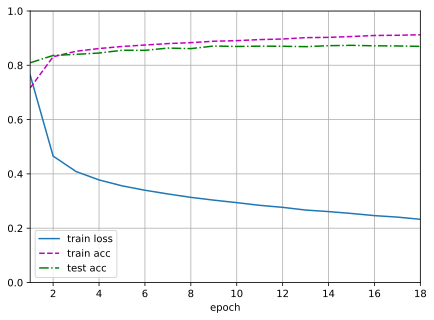

In [11]:
# Training of model over 18 epochs

num_epochs = 18
mu.train_ch3(net, train, test, loss, num_epochs, optimizer)

**Final Model Accuracy**

In [13]:
# Testing of accuracy on test set after training
mu.evaluate_accuracy(net, test)

0.8697